In [1]:
# ほぼコピペだが、巡回路制約は補助変数を使うMTZ制約に変更した
# https://qiita.com/r_nsd/items/19dcb30f5478384f90d3

In [2]:
import numpy as np
import pandas as pd
import pulp
from scipy.spatial import distance_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2, suppress = True)

In [3]:
N = 10
C = 50 #Capacity per vehicle 

In [4]:
df = pd.DataFrame({"x":np.random.randint(0, 100, N), 
                   "y":np.random.randint(0, 100, N), 
                   "weight":np.random.randint(5, 20, N)})

# 0 for base
df.iloc[0].x = 50
df.iloc[0].y = 50
df.iloc[0].weight = 0

df

,x,y,weight
0,50,50,0
1,74,58,17
2,17,0,14
3,0,41,12
4,61,76,14
5,8,96,5
6,93,21,7
7,37,52,15
8,31,67,12
9,65,10,9


In [5]:
print("total weight", df.weight.sum())
print('minimum number of vehicles: ', np.ceil(df.weight.sum()/C))

total weight 105
minimum number of vehicles:  3.0


In [6]:
V = int(np.ceil(df.weight.sum()/C)) #num of vehicles、各荷物の重量配分によってはこれでできない可能性もあるかもしれない 

In [7]:
distance = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index).values

distance[0]

array([ 0.  , 30.48, 61.52, 52.2 , 31.51, 62.49, 52.34, 19.95, 28.18,
       43.66])

(-10.0, 110.0)

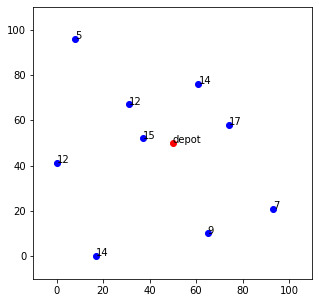

In [8]:
plt.figure(figsize=(5,5))
for i in range(N):    
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='r')
        plt.text(df.x[i], df.y[i], "depot")
    else:
        plt.scatter(df.x[i], df.y[i], c='b')
        plt.text(df.x[i], df.y[i], df.weight[i])
plt.xlim([-10, 110])
plt.ylim([-10, 110])

In [9]:
problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

In [10]:
x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(V)]for j in range(N)] for i in range(N)]
x[0]

[[None, None, None],
 [x0_1,0, x0_1,1, x0_1,2],
 [x0_2,0, x0_2,1, x0_2,2],
 [x0_3,0, x0_3,1, x0_3,2],
 [x0_4,0, x0_4,1, x0_4,2],
 [x0_5,0, x0_5,1, x0_5,2],
 [x0_6,0, x0_6,1, x0_6,2],
 [x0_7,0, x0_7,1, x0_7,2],
 [x0_8,0, x0_8,1, x0_8,2],
 [x0_9,0, x0_9,1, x0_9,2]]

In [11]:
u = [pulp.LpVariable("u(%s)"%(i), cat="Continuous", lowBound=1.0, upBound=(N)) for i in range(N)]
u

[u(0), u(1), u(2), u(3), u(4), u(5), u(6), u(7), u(8), u(9)]

In [12]:
# 最小化を目指す目的関数
problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0 for k in range(V) for j in range(N) for i in range (N))

In [13]:
for j in range(1, N):
    problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(N) for k in range(V)) == 1 

In [14]:
for k in range(V):
    problem += pulp.lpSum(x[0][j][k] for j in range(1, N)) == 1
    problem += pulp.lpSum(x[i][0][k] for i in range(1, N)) == 1

In [15]:
for k in range(V):
    for j in range(N):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(N)) -  pulp.lpSum(x[j][i][k] for i in range(N)) == 0

In [16]:
for k in range(V):
    problem += pulp.lpSum(df.weight[j] * x[i][j][k] if i != j else 0 for i in range(N) for j in range (1, N)) <= C 

In [17]:
#部分巡回路除去制約で補助変数を使わない場合
#subtours = []
#for i in range(2, N):
#    subtours += itertools.combinations(range(1, N), i)
#for s in subtours:
#    problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(V)) <= len(s) - 1

In [18]:
# 部分巡回路MTZ制約
for i in range(N):
    for j in range(1, N):
        if i != j:
            problem += u[i] + 1.0 <= u[j] + (N - 1)*(1.0 - pulp.lpSum(x[i][j][k] for k in range(V)))

In [19]:
print(problem)

CVRP:
MINIMIZE
30.479501308256342*x0_1,0 + 30.479501308256342*x0_1,1 + 30.479501308256342*x0_1,2 + 61.5223536610881*x0_2,0 + 61.5223536610881*x0_2,1 + 61.5223536610881*x0_2,2 + 52.20153254455275*x0_3,0 + 52.20153254455275*x0_3,1 + 52.20153254455275*x0_3,2 + 31.51190251317746*x0_4,0 + 31.51190251317746*x0_4,1 + 31.51190251317746*x0_4,2 + 62.489999199871974*x0_5,0 + 62.489999199871974*x0_5,1 + 62.489999199871974*x0_5,2 + 52.3354564325181*x0_6,0 + 52.3354564325181*x0_6,1 + 52.3354564325181*x0_6,2 + 19.949937343260004*x0_7,0 + 19.949937343260004*x0_7,1 + 19.949937343260004*x0_7,2 + 28.178005607210743*x0_8,0 + 28.178005607210743*x0_8,1 + 28.178005607210743*x0_8,2 + 43.657759905886145*x0_9,0 + 43.657759905886145*x0_9,1 + 43.657759905886145*x0_9,2 + 30.479501308256342*x1_0,0 + 30.479501308256342*x1_0,1 + 30.479501308256342*x1_0,2 + 81.37567204023571*x1_2,0 + 81.37567204023571*x1_2,1 + 81.37567204023571*x1_2,2 + 76.0920495189872*x1_3,0 + 76.0920495189872*x1_3,1 + 76.0920495189872*x1_3,2 + 22.4

In [20]:
status = problem.solve()

In [21]:
print('Vehicle num:', V)
print("Status: ", pulp.LpStatus[status])
print('Objective: ', problem.objective.value())

Vehicle num: 3
Status:  Optimal
Objective:  438.2205694954325


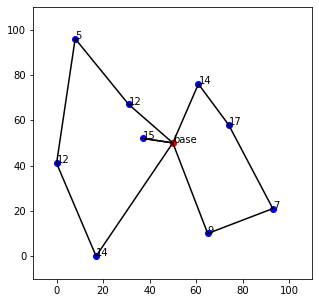

In [22]:
plt.figure(figsize=(5,5))
for i in range(N):    
    if i == 0:
        plt.scatter(df.x[i], df.y[i], c='r')
        plt.text(df.x[i], df.y[i], "base")
    else:
        plt.scatter(df.x[i], df.y[i], c='b')
        plt.text(df.x[i], df.y[i], df.weight[i])
plt.xlim([-10, 110])
plt.ylim([-10, 110])

for k in range(V):
    for i in range(N):
        for j in range(N):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.x[i], df.x[j]], [df.y[i], df.y[j]], c="black")